<a href="https://colab.research.google.com/github/sumankmaiti/All-in-one/blob/main/Encoder_Heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 38s 14ms/step - loss: 0.2145 - val_loss: 0.1445
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1355 - val_loss: 0.1265
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1236 - val_loss: 0.1197
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1178 - val_loss: 0.1146
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1143 - val_loss: 0.1121
Epoch 6/50
469/469 [==============================] - 5s 10ms/step - loss: 0.1120 - val_loss: 0.1096
Epoch 7/50
469/469 [==============================] - 5s 10ms/step - loss: 0.1100 - val_loss: 0.1083
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1085 - val_loss: 0.1068
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1073 - val_loss: 0.1053
Epoch 10/50
469/469 [==============================] - 5s 10ms/step - loss: 0.1062 - val_l

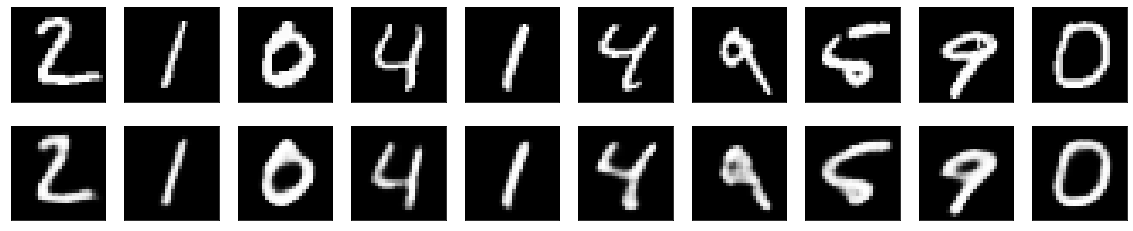

In [ ]:
# outputs
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

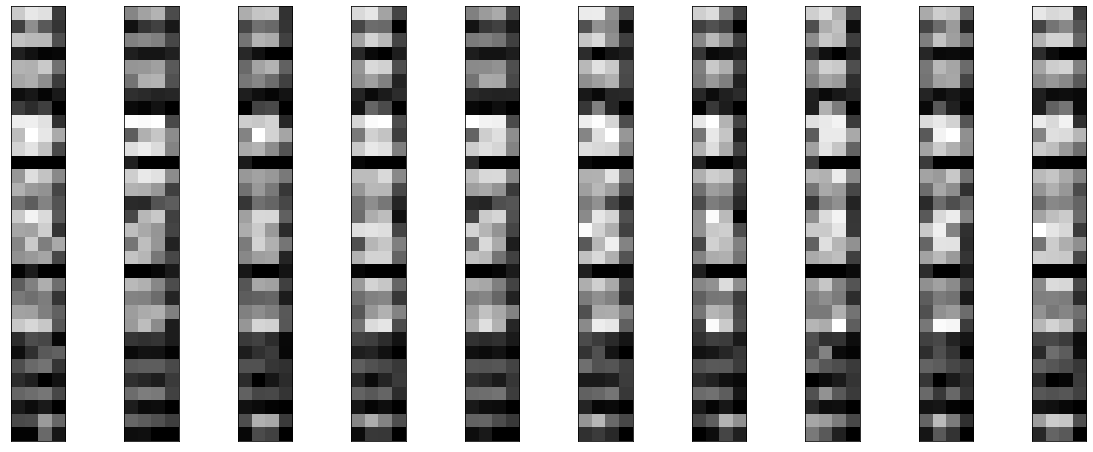

In [ ]:
# visualize the latents
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead

In [ ]:
# input
y = x_test[0]
y = np.expand_dims(y, axis=0)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = autoencoder.get_layer('conv2d_3')
  iterate = tf.keras.models.Model([autoencoder.inputs], [autoencoder.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(y) # for a given input predected output
  print("output shape", model_out.shape)
  print("layer shape", last_conv_layer.shape)
  # class_out = model_out[:, np.argmax(model_out[0])]
  # print("probablity of the predicted class", class_out)
  grads = tape.gradient(model_out, last_conv_layer)  # compute gradient based on predected probablity and class index
  print("Gradints of w.r.t predicted class", grads.shape) 
  pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Global avarage pooling
  print("Global Avarage pooling", pooled_grads.shape)

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1) # heatmap by mean along with feature map axis
print("heatmap shape", heatmap.shape)

output shape (1, 28, 28, 1)
layer shape (1, 4, 4, 8)
Gradints of w.r.t predicted class (1, 4, 4, 8)
Global Avarage pooling (8,)
heatmap shape (1, 4, 4)


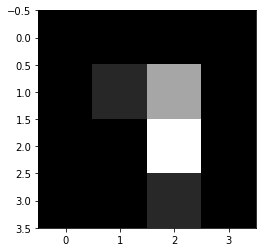

In [ ]:
heatmap = np.maximum(heatmap, 0)  # convert negative values to 0
heatmap /= np.max(heatmap)  # normalize
heatmap = heatmap.reshape((4, 4))
plt.imshow(heatmap)
plt.show()

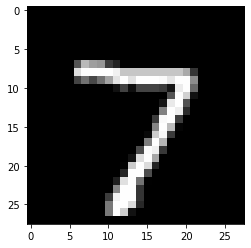

In [ ]:
img = x_test[0]
plt.imshow(img.reshape(28, 28))

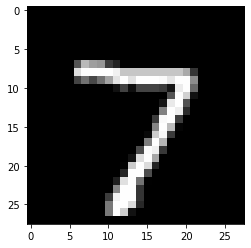

In [ ]:
img = cv2.imread(img)

INTENSITY = 0.5

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

img = heatmap * INTENSITY + img

In [ ]:
cv2_imshow(x_test[0])
cv2_imshow(img)